# A/B Testing Analysis: Average vs Maximum Bidding Models

## Project Overview
Analyzing the performance of two impression bidding strategies for an ad-tech company's retargeting campaign to determine which model drives better conversions.

## Key Metrics

| Metric | Formula | Purpose |
|--------|---------|---------|
| **CTR** (Click-Through Rate) | `# Website Clicks / # Impressions` | Measures ad effectiveness in attracting clicks |
| **CR** (Conversion Rate) | `# Purchases / # Website Clicks` | Shows percentage of clicks that result in purchases |
| **CPC** (Cost Per Click) | `Spend / # Website Clicks` | Evaluates efficiency of ad spend per click |
| **CPA** (Cost Per Acquisition) | `Spend / # Purchases` | Average cost to acquire a customer |

---

## Hypothesis Testing

**Null Hypothesis (H₀):** No significant difference in performance between Average Bidding and Maximum Bidding  
**Alternative Hypothesis (H₁):** Significant difference exists between the two bidding models  

**Significance Level (α):** 0.05

---

## Dataset Variables
- Campaign Name
- Date
- Spend [USD]
- \# of Impressions
- Reach
- \# of Website Clicks
- \# of Searches
- \# of View Content
- \# of Add to Cart
- \# of Purchase

## Import libraries & dataset

In [1]:
# Install pingouin library
!pip install pingouin

# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import pingouin
%matplotlib inline

# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

## Data loading & merging

In [2]:
# Import dataset
import kagglehub

path = kagglehub.dataset_download('ilkeryildiz/example-dataset-for-ab-test')

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'example-dataset-for-ab-test' dataset.
Path to dataset files: /kaggle/input/example-dataset-for-ab-test


In [3]:
# Convert each csv to dataframe
test = pd.read_csv('/kaggle/input/example-dataset-for-ab-test/test_group.csv', delimiter = ';')
control = pd.read_csv('/kaggle/input/example-dataset-for-ab-test/control_group.csv', delimiter = ';')

In [4]:
# Show first rows of test dataframe
test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


In [5]:
# Show first rows of control dataframe
control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Concatenate dataframes
df = pd.concat([test, control], axis = 0)
df = df.reset_index(drop = True)

# Drop unnecessary columns
df.drop(['Reach', '# of Searches', '# of View Content', '# of Add to Cart'], axis=1, inplace=True)

# Display new dataset
df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,# of Website Clicks,# of Purchase
0,Test Campaign,1.08.2019,3008,39550.0,3038.0,255.0
1,Test Campaign,2.08.2019,2542,100719.0,4657.0,677.0
2,Test Campaign,3.08.2019,2365,70263.0,7885.0,578.0
3,Test Campaign,4.08.2019,2710,78451.0,4216.0,340.0
4,Test Campaign,5.08.2019,2297,114295.0,5863.0,768.0


## Data cleaning

In [7]:
# Obtain number of missing values by column
df.isna().sum()

,0
Campaign Name,0
Date,0
Spend [USD],0
# of Impressions,1
# of Website Clicks,1
# of Purchase,1


In [8]:
# Subset the dataframe to show rows with missing data
df[df.isnull().any(axis=1)]

,Campaign Name,Date,Spend [USD],# of Impressions,# of Website Clicks,# of Purchase
34,Control Campaign,5.08.2019,1835,NaN,NaN,NaN


In [9]:
# Impute the mean by subgroups
var_dict = df.groupby('Campaign Name')[['# of Impressions', '# of Website Clicks', '# of Purchase']].mean().round(0).to_dict()

for dict_id, dict_info in var_dict.items():
    df[str(dict_id)] = df[str(dict_id)].fillna(df['Campaign Name'].map(dict_info))

In [10]:
# Check again
df.isna().sum()

,0
Campaign Name,0
Date,0
Spend [USD],0
# of Impressions,0
# of Website Clicks,0
# of Purchase,0


## Simple EDA

In [11]:
# Show first rows of the data
df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,# of Website Clicks,# of Purchase
0,Test Campaign,1.08.2019,3008,39550.0,3038.0,255.0
1,Test Campaign,2.08.2019,2542,100719.0,4657.0,677.0
2,Test Campaign,3.08.2019,2365,70263.0,7885.0,578.0
3,Test Campaign,4.08.2019,2710,78451.0,4216.0,340.0
4,Test Campaign,5.08.2019,2297,114295.0,5863.0,768.0


In [12]:
# Obtain information from the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        60 non-null     object 
 1   Date                 60 non-null     object 
 2   Spend [USD]          60 non-null     int64  
 3   # of Impressions     60 non-null     float64
 4   # of Website Clicks  60 non-null     float64
 5   # of Purchase        60 non-null     float64
dtypes: float64(3), int64(1), object(2)
memory usage: 2.9+ KB


In [13]:
# Change 'Date' data type to date
df['Date'] = pd.to_datetime(df["Date"], dayfirst = True).dt.date

# Change 'Spend [USD]' from integer to float
df['Spend [USD]'] = df['Spend [USD]'].astype(float)

In [14]:
# Obtain summary statistics of the data
df.describe()

,Spend [USD],# of Impressions,# of Website Clicks,# of Purchase
count,60.000000,60.000000,60.000000,60.000000
mean,2425.750000,92072.283333,5676.566667,522.016667
std,381.130461,32270.543500,1740.469149,195.297556
min,1757.000000,22521.000000,2277.000000,222.000000
25%,2073.750000,69558.250000,4230.750000,340.000000
50%,2420.500000,98281.000000,5581.000000,506.000000
75%,2727.500000,117160.500000,7201.250000,685.000000
max,3112.000000,145248.000000,8264.000000,890.000000


In [15]:
# Count the values in each categorical column
df['Campaign Name'].value_counts()

,count
Campaign Name,
Test Campaign,30
Control Campaign,30


First let's create bar charts for totals and metrics to see if there are any visual differences between the campaigns

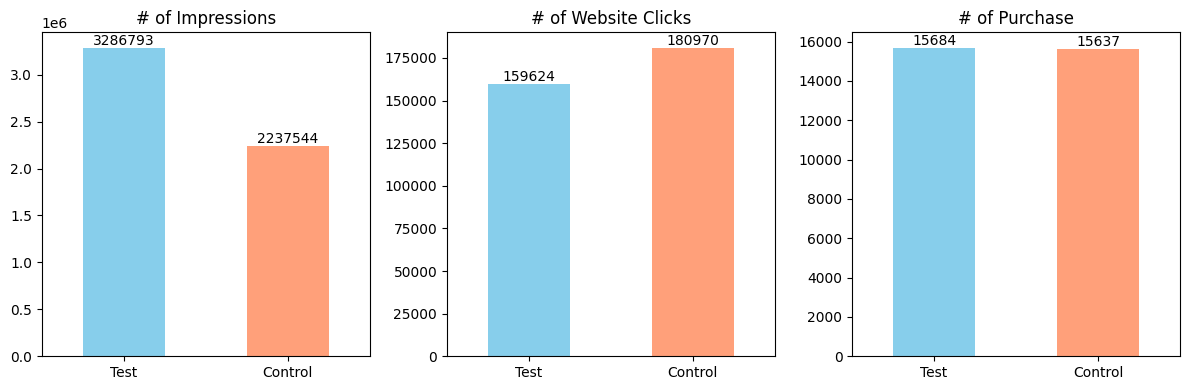

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
num_vars = ['# of Impressions', '# of Website Clicks', '# of Purchase']

for i, var in enumerate(num_vars):
    totals = df.groupby('Campaign Name')[var].sum()
    totals.plot(kind='bar', ax=axes[i], color=['#87CEEB', '#FFA07A'], rot=0)
    axes[i].set_title(var)
    axes[i].set_xlabel('')
    axes[i].set_xticklabels(['Test', 'Control'])

    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.0f')

plt.tight_layout()
plt.show()

It appears that the control campaign got more impressions and conversions, while the experimental campaign got more clicks. Next let's explore the visual differences using other plots

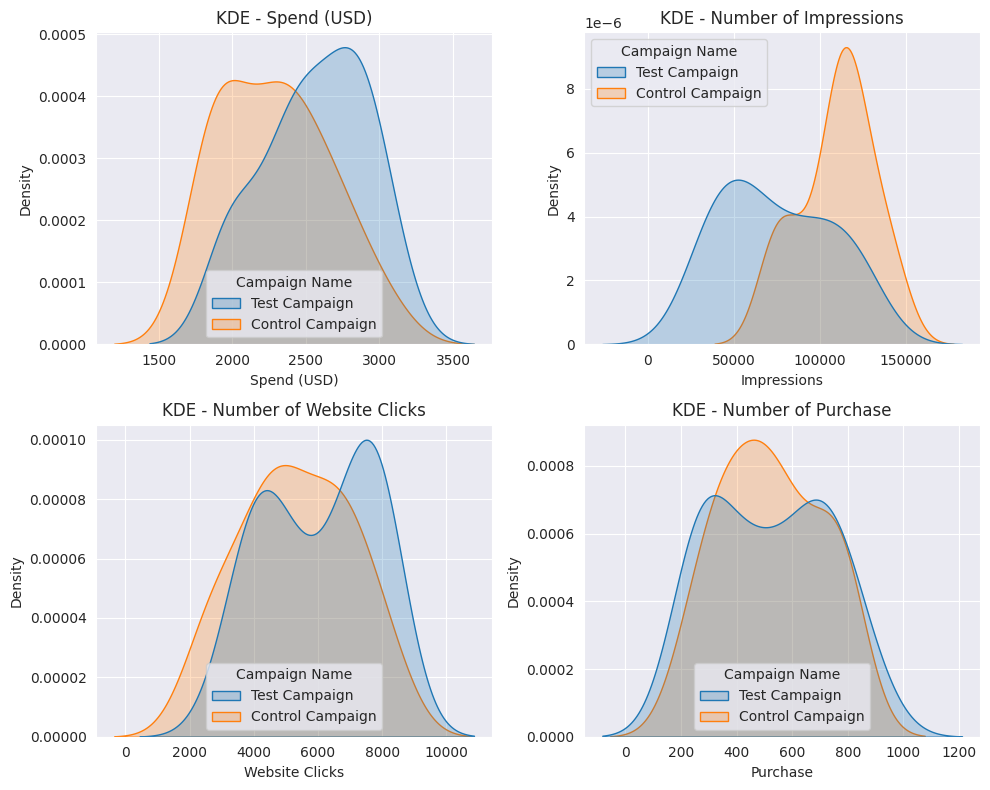

In [17]:
# Set an style for the plots
sns.set_style('darkgrid')

# Create a fig and axis for a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Create a kde plot for each numerical variable
sns.kdeplot(data=df, x = 'Spend [USD]', ax=axes[0, 0], hue = 'Campaign Name', fill = True)
sns.kdeplot(data=df, x = '# of Impressions', ax=axes[0, 1], hue = 'Campaign Name', fill = True)
sns.kdeplot(data=df, x = '# of Website Clicks', ax=axes[1, 0], hue = 'Campaign Name', fill = True)
sns.kdeplot(data=df, x = '# of Purchase', ax=axes[1, 1], hue = 'Campaign Name', fill = True)

# Add labels and titles to each plot
axes[0, 0].set_xlabel("Spend (USD)")
axes[0, 0].set_ylabel("Density")
axes[0, 0].set_title("KDE - Spend (USD)")

axes[0, 1].set_xlabel("Impressions")
axes[0, 1].set_ylabel("Density")
axes[0, 1].set_title("KDE - Number of Impressions")

axes[1, 0].set_xlabel("Website Clicks")
axes[1, 0].set_ylabel("Density")
axes[1, 0].set_title("KDE - Number of Website Clicks")

axes[1, 1].set_xlabel("Purchase")
axes[1, 1].set_ylabel("Density")
axes[1, 1].set_title("KDE - Number of Purchase")

plt.tight_layout()

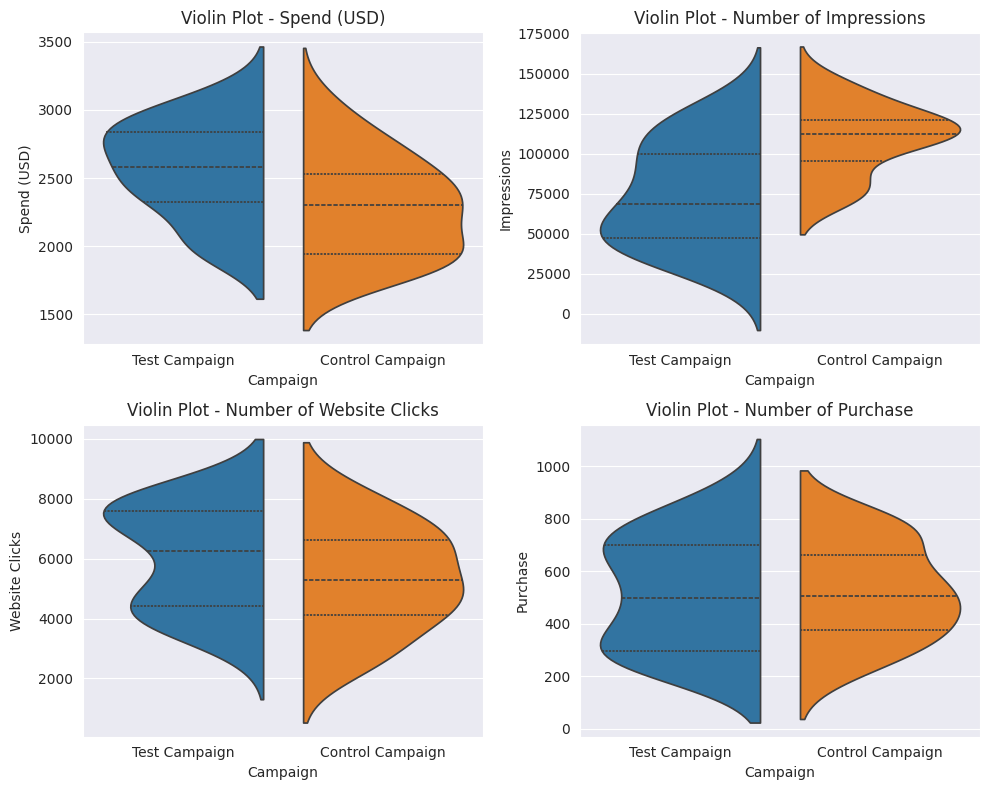

In [18]:
# Set an style for the plots
sns.set_style('darkgrid')

# Create a fig and axis for a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Create a split violin plot for each numerical variable
sns.violinplot(data=df, x='Campaign Name', y='Spend [USD]', ax=axes[0, 0], hue='Campaign Name', legend=False, split=True, inner='quartile')
sns.violinplot(data=df, x='Campaign Name', y='# of Impressions', ax=axes[0, 1], hue='Campaign Name', legend=False, split=True, inner='quartile')
sns.violinplot(data=df, x='Campaign Name', y='# of Website Clicks', ax=axes[1, 0], hue='Campaign Name', legend=False, split=True, inner='quartile')
sns.violinplot(data=df, x='Campaign Name', y='# of Purchase', ax=axes[1, 1], hue='Campaign Name', legend=False, split=True, inner='quartile')

# Add labels and titles to each plot
axes[0, 0].set_xlabel("Campaign")
axes[0, 0].set_ylabel("Spend (USD)")
axes[0, 0].set_title("Violin Plot - Spend (USD)")

axes[0, 1].set_xlabel("Campaign")
axes[0, 1].set_ylabel("Impressions")
axes[0, 1].set_title("Violin Plot - Number of Impressions")

axes[1, 0].set_xlabel("Campaign")
axes[1, 0].set_ylabel("Website Clicks")
axes[1, 0].set_title("Violin Plot - Number of Website Clicks")

axes[1, 1].set_xlabel("Campaign")
axes[1, 1].set_ylabel("Purchase")
axes[1, 1].set_title("Violin Plot - Number of Purchase")

plt.tight_layout()
plt.show()

**Spend (USD)**
- Test Campaign has higher average spend

**Number of Impressions**
- Test Campaign has lower number of impressions, but has greater variability overall

**Website Clicks**
- Test Campaign's number of website clicks is marginally higher

**Number of Purchases**
- About the same for both

**Next Step**: Statistical testing needed to determine if differences are significant and cost-effective

## Statistical Testing

In [19]:
# Create a new colum and perform calculations for each metric

# Click-Through Rate (CTR) - Helps measure the effectiveness of ads in attracting clicks
df['CTR'] = df['# of Website Clicks'] / df['# of Impressions']

# Conversion Rate (CR) - Shows what percentage of visitors who clicked on the ad actually made a purchase
df['CR'] = df['# of Purchase'] / df['# of Website Clicks']

# Cost Per Click (CPC) - It allows you to evaluate the efficiency of advertising expenses to generate clicks
df['CPC'] = df['Spend [USD]'] / df['# of Website Clicks']

# Cost Per Acquisition (CPA) - Refers to the average cost a company pays to acquire a new customer
df['CPA'] = df['Spend [USD]'] / df['# of Purchase']


# Show results
df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,# of Website Clicks,# of Purchase,CTR,CR,CPC,CPA
0,Test Campaign,2019-08-01,3008.0,39550.0,3038.0,255.0,0.076814,0.083937,0.990125,11.796078
1,Test Campaign,2019-08-02,2542.0,100719.0,4657.0,677.0,0.046238,0.145373,0.545845,3.754801
2,Test Campaign,2019-08-03,2365.0,70263.0,7885.0,578.0,0.112221,0.073304,0.299937,4.091696
3,Test Campaign,2019-08-04,2710.0,78451.0,4216.0,340.0,0.053741,0.080645,0.642789,7.970588
4,Test Campaign,2019-08-05,2297.0,114295.0,5863.0,768.0,0.051297,0.130991,0.391779,2.990885


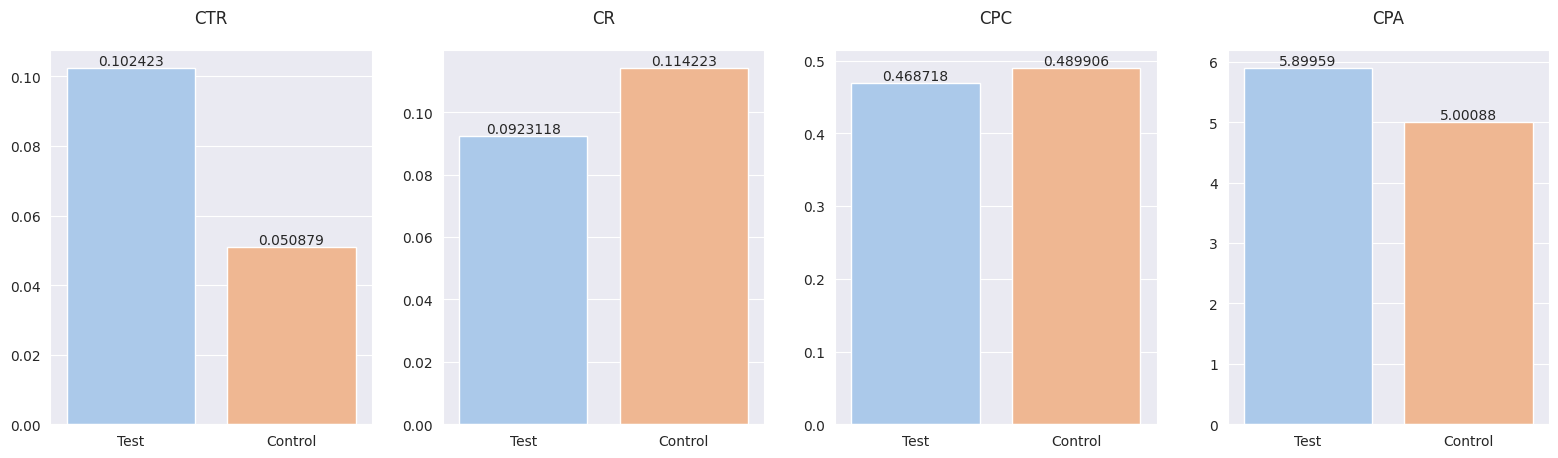

In [20]:
# Create a bar chart for each metric
# Create a list of the columns containing the metrics
metrics = ['CTR', 'CR', 'CPC', 'CPA']

n = 1
plt.figure(figsize= (16, 5))

for m in metrics:
    plt.subplot(1, 4, n)

    # Create the plot
    g = sns.barplot(data=df, y=m, x= 'Campaign Name', palette = 'pastel', estimator = 'mean', errorbar=('ci', False))

    g.set_xlabel(None)
    g.set_ylabel(None)
    g.set_title(f'{m}', y =1.05)
    plt.xticks(ticks=range(2), labels=['Test', 'Control'])
    for i in g.containers:
        g.bar_label(i,)

    n = n + 1
    plt.tight_layout(pad = 2.2)

The control group seems to perform better for the Conversion Rate (CR) and Cost Per Acquisition (CPA) metrics, which could indicate that the control campaign is better at converting clicks into purchases and uses monetary resources more efficiently (lower CPA) to obtain more purchases. On the other hand, the experimental group shows better results for the Click-Through Rate (CTR) and Cost Per Click (CPC) metrics, indicating that the experimental campaign is better at attracting clicks and uses monetary resources more efficiently to generate clicks.

However, are these differences statistically significant?

### Statisical Test using Mann Whitney U Test
- used when data do not meet the assumptions of normality

In [21]:
# Create a function to perform Mann Whitney U Test on all metrics
def mann_whitney_u(metric, alpha):

    # Convert table to wide format using pivot
    df_wide = df.pivot(columns = 'Campaign Name', values = metric)

    # Use mwu from pingouin to perform the test
    test = pingouin.mwu(
                 x = df_wide['Control Campaign'],
                 y = df_wide['Test Campaign'],
                 alternative = 'two-sided'
                )

    # Save p-value from the test
    p_value = test.loc['MWU', 'p-val'].round(5)

    # Print a result based on level of significance (alpha)
    print('\nMann Whitney U test for {}:\n'.format(metric))
    print(f'\t- p value is {p_value}\n')

    if p_value < alpha:
        print('\nWe reject the null hypothesis, there is sufficient evidence to affirm that there is a statistically significant difference between Control and Test {}.'.format(metric))

    else:
        print('\nWe fail to reject the null hypothesis, there is sufficient evidence to affirm that there is no statistically significant difference between Control and Test {}.'.format(metric))

#### CTR - Click-Through Rate


* **Null Hypothesis (H0):** There is no difference in CTR between Average Bidding and Maximum Bidding.
* **Alternative Hypothesis (H1):** There is a significant difference in CTR between Average Bidding and Maximum Bidding.

Significance level is 0.05.

In [22]:
# Performn MWU test for CTR metric
mann_whitney_u(metric = 'CTR', alpha = 0.05)


Mann Whitney U test for CTR:

	- p value is 0.00021


We reject the null hypothesis, there is sufficient evidence to affirm that there is a statistically significant difference between Control and Test CTR.


#### CR - Conversion Rate


* **Null Hypothesis (H0):** There is no difference in CR between Average Bidding and Maximum Bidding.
* **Alternative Hypothesis (H1):** There is a significant difference in CR between Average Bidding and Maximum Bidding.

Significance level is 0.05.

In [23]:
# Performn MWU test for CR metric
mann_whitney_u(metric = 'CR', alpha = 0.05)


Mann Whitney U test for CR:

	- p value is 0.28378


We fail to reject the null hypothesis, there is sufficient evidence to affirm that there is no statistically significant difference between Control and Test CR.


#### CPC - Cost Per Click


* **Null Hypothesis (H0):** There is no difference in CPC between Average Bidding and Maximum Bidding.
* **Alternative Hypothesis (H1):** There is a significant difference in CPC between Average Bidding and Maximum Bidding.

Significance level is 0.05.

In [24]:
# Performn MWU test for CPC metric
mann_whitney_u(metric = 'CPC', alpha = 0.05)


Mann Whitney U test for CPC:

	- p value is 0.87663


We fail to reject the null hypothesis, there is sufficient evidence to affirm that there is no statistically significant difference between Control and Test CPC.


#### CPA - Cost Per Acquisition


* **Null Hypothesis (H0):** There is no difference in CPA between Average Bidding and Maximum Bidding.
* **Alternative Hypothesis (H1):** There is a significant difference in CPA between Average Bidding and Maximum Bidding.

Significance level is 0.05.

In [25]:
# Performn MWU test for CPA metric
mann_whitney_u(metric = 'CPA', alpha = 0.05)


Mann Whitney U test for CPA:

	- p value is 0.22823


We fail to reject the null hypothesis, there is sufficient evidence to affirm that there is no statistically significant difference between Control and Test CPA.


## Summary

The test results showed that the conversion rate (CR), cost per click (CPC) and cost per acquisition (CPA) have no statistically significant differences between the groups, so no conclusions could be drawn as to which bidding model is better based on these metrics.

Nevertheless, the Mann-Whitney U test shows that there is statistically significant evidence to affirm that the two campaigns are different in terms of the CTR (Click-Through Rate) metric, which helps us to measure the effectiveness of ads in attracting clicks. In this context, the results of the analysis indicate that, on average, the experimental group obtains a significantly higher CTR than the control group, as it was evaluated by analyzing the bar charts.